## Trying to get un-stuck on a seemingly simple ODE  problem

In [3]:
# using JuMP
# using Ipopt
using DataFrames, CSV
using Plots
using DifferentialEquations
using Distributions
using NLsolve

include("fast_quadprog.jl")


quadprog_fastSolve (generic function with 1 method)

### Overview
This notebook details a "simple" procurement auction equilibrium computation, for auctions of the form described [here](https://scholar.harvard.edu/files/vasserman/files/bv_sept2019.pdf).

For some shorter notes working out the math for this example in full see [here](https://github.com/shoshievass/PublicFiles/blob/master/Julia/baseline_equilibrium_derivation_risk_aversion_note.pdf). For a better high-level explanation of what's going on, aimed at extending this model to a two-dimensional type version, see [here](https://github.com/shoshievass/PublicFiles/blob/master/Julia/two_type_equilibrium_note.pdf).

I present the ODE and a working solution, using an upper bound as an initial condition. I then try to solve the ODE in the "inverse", using a guessed lower bound as an initial condition. 

The reason for trying to solve the inverse problem is that I ultimately want to solve a boundary-value problem where two ODEs of this form need to be solved simultaneously subject to having the same values at the boundaries. One way to try to solve the boundary value problem is to use a shooting algorithm in which I solve the two inverse ODE problems with guessed initial values and check if they match at the upper boundary.

Currently, the inverse problem doesn't work -- most likely for numerical reasons that I don't understand.

### The ODE

The ODE problem maps a bounded interval of "types" $\alpha \in \left[ \underline{\alpha}, \overline{\alpha} \right]$ to "scores" $s \in \left[ \underline{s}, \overline{s} \right]$ according to the differential equations:

$$
s'(\alpha) = \frac{f(\alpha)}{1-F(\alpha)} \cdot \frac{V(s, \alpha, p)}{V'(s , \alpha, p)}
$$

Here:
- $f(\alpha)$ and $F(\alpha)$ are the pdf and cdf of the distrubiton with which the types $\alpha$ are distributed -- which we will assume is a uniform distribution for simplicity. 

- That is, $f(x) = \frac{1}{\overline{\alpha} - \underline{\alpha}}$ and $F(x) = \frac{x - \underline{\alpha}}{\overline{\alpha} - \underline{\alpha}}$ 

- $ V(s , \alpha, p) $ is a "value function" evaluated at $s, \alpha$ and a vector of parameters $p$. More details on this in a bit.

- $V'(s , \alpha, p) = \frac{\partial V}{\partial s} V(s , \alpha, p)$ is the derivative of the value function with respect to s.

### Multiple (Asymmetric) Gamma Problem

The problem described above has an additional latent parameter that is treated as fixed: $\gamma$. 

For my current endeavor, I need to solve a closely related problem where there are multiple types of $\gamma$. The tricky thing is that in order for each $\gamma$ type's ODE to be well defined, they need to be "in equilibrium with each other".

#### The Problem Definition

There are $N=2$ types of bidders $i$, each of whom has some value of $\gamma$. 

We are interested in solving for the "equilibrium bidding" function that maps each possible type $(\tilde{\alpha}, {\gamma}_i)$ to a "score" $s_i(\tilde{\alpha}, {\gamma}_i)$. 

We can think the "score" function as a map:
$$
s_i : [\underline{\alpha}, \overline{\alpha}] \rightarrow [\underline{S}, \overline{S}]
$$

where each of $[\underline{\alpha}, \overline{\alpha}]$ and $[\underline{S}, \overline{S}]$ are subsets of $\mathbb{R}_{+}$. 

In order for a prospective "score" function to be an equilibrium, it needs maximize the "expected utility" from participating in the auction for each possible bidder type $(\tilde{\alpha}, \tilde{\gamma})$ --- let's call this $EU(\tilde{\alpha}, {\gamma}_i, s_i(\tilde{\alpha}))$.

This is the product of the (expected) utility that the bidder would get from completing the project if he wins (given his bid) times the probability that he wins.

$$
EU_i(\tilde{\alpha}, {\gamma}_i, s_i(\tilde{\alpha}, {\gamma}_i)) = \text{E}[u(\pi(\tilde{\alpha}, {\gamma}_i, s_i(\tilde{\alpha}, {\gamma}_i))) \text{ | win}] \times \text{Pr(win | } s_i(\tilde{\alpha}) \text{ )}
$$


The rules of the auction are that the bidder with the **lowest** score wins the auction. Thus, we can write 
$$
\text{Pr(win | } s(\tilde{\alpha}, \tilde{\gamma}) \text{ )} = \text{Pr(} s(\tilde{\alpha}, \tilde{\gamma}) < \text{ all other bidders' scores)}
$$

That is, the probability that bidder $i$ will win using a score $s_i(\tilde{\alpha})$ is the probability that the other bidder $j$ will bid a higher score than that.

**Crucially** in equilibrium, the bidders are "best responding" to each other's score functions. 

That is:
$$
\text{Pr(} s(\tilde{\alpha}, \tilde{\gamma}) < \text{ all other bidders' scores)} = 
\text{Pr(} s_i(\tilde{\alpha}) < s_j(\alpha_j) \text{ )} \\ =
\text{Pr(} s_j^{-1}(s_i(\tilde{\alpha})) < \alpha_j \text{ )}
$$

where $\alpha_j$ is an IID random draw from the distribution of $\alpha$.

Writing $$
V(s, \hat{\alpha}, \gamma_i, p) \equiv \text{E}[u(\pi(\tilde{\alpha}, {\gamma}_i, s_i(\hat{\alpha}))) \text{ | win}]
$$
for notational ease, we can rewrite the expected utility equation above:

$$
EU_i(\tilde{\alpha}, {\gamma}_i, s_i(\tilde{\alpha})) = V_i(s, \hat{\alpha}, \gamma_i, p) \times \text{Pr(} s_j^{-1}(s_i(\tilde{\alpha})) < \alpha_j \text{ )}.
$$

We can then derive the system of differential equations by taking the first order condition:

### Boundary Value Problem ODE Definition

Denote $\psi_i(\tilde{s}) = s_i^{-1}(\tilde{s})$ for the inverse function of the mapping $s_i$.

$$
\psi_i'(s_j) = \frac{f(\psi_i(\alpha_j))}{1-F(\psi_j(\alpha_j))} \cdot \frac{V(s_j, \alpha_j, p)}{V'(s_j , \alpha_j, p)}
$$

where:
- $f(\alpha)$ and $F(\alpha)$ are the pdf and cdf of the distrubiton with which the types $\alpha$ are distributed -- which we will assume is a uniform distribution for simplicity. 

- That is, $f(x) = \frac{1}{\overline{\alpha} - \underline{\alpha}}$ and $F(x) = \frac{x - \underline{\alpha}}{\overline{\alpha} - \underline{\alpha}}$ 

- $ V(s , \alpha, p) $ is a "value function" evaluated at $s, \alpha$ and a vector of parameters $p$. More details on this in a bit.

- $V'(s , \alpha, p) = \frac{\partial V}{\partial s} V(s , \alpha, p)$ is the derivative of the value function with respect to s.

#### Boundary Conditions

What makes this a boundary problem is:
1. The ODEs for $i$ and $j$ have to be solved together
2. Both boundary scores have to be the same: 
$$ 
s_i(\overline{\alpha}) = s_j(\overline{\alpha}) \text{  and  } s_i(\underline{\alpha}) = s_j(\underline{\alpha})
$$
3. There is a known initial condition that (supposing that $\gamma_j < \gamma_i$): 

    - $s_i(\overline{\alpha})$ must be the smallest value of $s$ s.t. $V(s , \overline{\alpha}, p) = 0 $

In [4]:
# function ds_da_ode( s, alpha, params)
    
# #     f_over_oneMinusF = f_over_one_minus_F_uniform(alpha, 0.49999, 2.00001)
    
#     f_over_oneMinusF = f_over_one_minus_F_lognormal_dist(alpha, 0., 0.12, 0.5, 2.01)

#     V_over_dV = getFracVdV(s, alpha, params)
    
#     ds_da = f_over_oneMinusF * V_over_dV; # Note: this should be a scalar
    
#     return(ds_da)

# end

function ds_da_ode( s, γ, α, params)
        
#     f_over_oneMinusF = f_over_F_uniform(α, 0.5, 2.0)
    f_over_oneMinusF = f_over_one_minus_F_lognormal_dist(α, 0., 0.12, 0.5, 2.01)

    V_over_dV = getFracVdV(s, γ, α, params)
    
    ds_da = f_over_oneMinusF * V_over_dV; # Note: this should be a scalar
    
    return(ds_da)

end

ds_da_ode (generic function with 1 method)

#### More Details

- Note that $\frac{f(\alpha)}{1-F(\alpha)}$ must be zero outside the support of $\alpha$. We define this below.

- The value function here is a bit complicated -- it requires solving a (simple) constrained quadratic formula to define:

$$
\begin{array}{c}V(s , \alpha, \mathbf{p}) = \arg\max\limits_{\{{b_t}(s)\}_t} \left[1-\exp \left(\sum_{t=1}^{T} \frac{\gamma^{2} \sigma_t^{2}}{2}\left(b_{t}(s)-\alpha c_{t}\right)^{2}-\gamma q_{t}^{a}\left(b_{t}(s)-\alpha c_{t}\right)\right)\right] \\ \text { s.t. } \sum_{t=1}^{T} b_{t}(s) q_{t}^{e}=s \\ \text { and } b_{t} \geq 0 \text { for each } t\end{array}
$$

where the parameter vector $ \mathbf{p}$ includes a whole bunch of parameters: $$ \mathbf{p} = \Big\{ \gamma, \{q_{t}^{a}\}_t,  \{q_{t}^{e}\}_t,\{\sigma_{t}^{2}\}_t \text{ and }  \{c_{t}\}_t  \Big\}$$

But we can solve this problem numerically for the vector of "bids" $b_{t}^{\ast}(s)$. Note that the optimal $b^{\ast}$ solution depends not just on $s$ but on $\alpha$ and all of the other parameters too, but we will keep everything except $s$ and $\alpha$ fixed for our ODE computation and for each $\alpha$ we will choose a single $s$.

In [5]:
function f_over_one_minus_F_uniform(z, a, b)
    if z < a 
        out = 0
    elseif z >= b
        out = 0
    else 
        out =  1.0/(b - z) 
    end
end

function f_over_one_minus_F_lognormal_dist(z, mu, sigma, a, b)
    alpha_dist = LogNormal(mu,sigma)

    f(x) = pdf(alpha_dist, x);
    F(x) = cdf(alpha_dist, x);
    
    out = (f(z) ./ (1 - F(z) - 0.000000001))
    
    return(out)
end

function getBidStar(s, γ, α, params)
    c, q_e, q_a, sigma_sq  = params
    
    T = length(q_e)
    
    b_tilde =  (γ * 0.5) * sigma_sq 
    a_tilde = (q_a + (γ * α * c) .* sigma_sq)
    s_tilde = s
    q_tilde = q_e
    
    sol = quadprog_fastSolve(a_tilde,b_tilde,q_tilde,s_tilde)
    
    return(sol)
end

function getDbDs(s, γ, α, b, params)
#     %Computes anayltical derivative of the optimal bid function of item t
#     % w.r.t. score s given alpha
    
    c, q_e, q_a, sigma_sq  = params

    T = length(q_e)
    pos_b = [ifelse(b[t] > 0, 1, 0) for t=1:T]

    if (sum(sigma_sq) > 0)
        denom = 1.0/(sum((q_e[t]^2 * pos_b[t]) / sigma_sq[t] for t in 1:T))
        db_ds = [((q_e[t] * pos_b[t] / sigma_sq[t]) * denom) for t in 1:T]'
    else
        db_ds = [ifelse(b[t] > 0, (1.0/q_e[t]), 0) for t=1:T]'
    end

    return(db_ds)

end

function getFracVdV(s, γ, α, params)
    
    c, q_e, q_a, sigma_sq  = params
                                                                
    b = getBidStar( s, γ, α, params)
    db_ds = getDbDs( s, γ, α, b, params)

    b_min_c = b - (α*c);

    profit_ce = (q_a' * b_min_c) - (γ)*0.5 * ((sigma_sq .* b_min_c)' * b_min_c)
        
    profit_term = exp(γ*profit_ce) - 1; 
    
    dce = db_ds * ((γ .* q_a) - (γ^2 .* sigma_sq .* b_min_c) );
        
    V_over_dV = profit_term / dce;
    
    return(V_over_dV)
    
end



getFracVdV (generic function with 1 method)

### Adding a Boundary Condition

To fully define this ODE problem we need an initial condition. For this problem, there is one point at which we know the solution: the "right" boundary.

From the economic theory, we must have the highest type of bidder, $\overline{\alpha}$ gets a value of zero at the solution: $V(s(\overline{\alpha}), \overline{\alpha}, p) = 0.$

Because $V(s, \alpha, p)$ doesn't have a closed form solution, we must solve for this upper bound numerically as well, by searching over the values of $s$ to find:

$$
\overline{s} = \arg\min\limits_{s} \big\{s : V( s, \overline{\alpha}, p) = 0 \big\}
$$

In [6]:
function getInsideV(s, γ, α, params)
    c, q_e, q_a, sigma_sq  = params
    
    b = getBidStar( s, γ, α, params)    

    b_min_c = b - (α*c);

    ce = (q_a' * b_min_c) - (γ/2) * ((sigma_sq .* b_min_c)' * b_min_c)
end

function getBoundarySMax( γ, α, params)
    c, q_e, q_a, sigma_sq  = params
    
    function ce_fun(svec)
        s_max_var = svec[1]
        return getInsideV(s_max_var, γ, α, params) 
    end
    
    starting_point = α*1.1*(c' * q_a)

    s_max_sol = nlsolve(ce_fun, [starting_point]; inplace = false)
    return s_max_sol.zero[1]
end

getBoundarySMax (generic function with 1 method)

### Solving an easy example

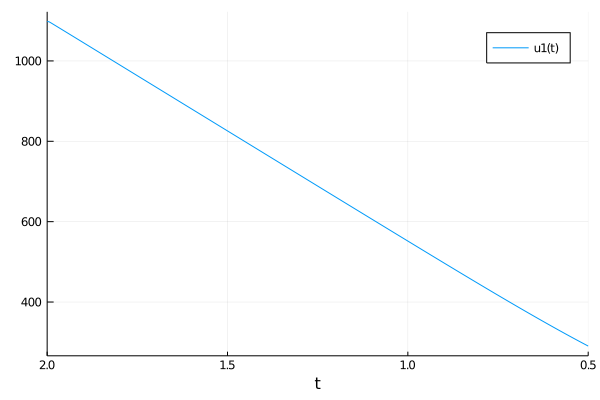

In [7]:
qa = [12; 40];
qe = [10; 50];
c0 = [5;10];
sigmasq = [3, 5];
gam = 1.5;

alpha_max = 2;
alpha_min = 0.5;

alpha_span = (alpha_max,alpha_min);

params = [c0, qe, qa, sigmasq]

s_max_computed = getBoundarySMax(gam, alpha_max, params)

ode_standard_subs(s, p, α) = ds_da_ode( s, gam, α, params )
ode_standard_prob = ODEProblem(ode_standard_subs, s_max_computed, alpha_span)

sol_standard =  DifferentialEquations.solve(ode_standard_prob, Rosenbrock23(autodiff=true))

plot(sol_standard)

## Solving in Reverse -- Things Break, but Why?

If this is the correct solution, then using the right value for $s(\underline{\alpha})$ should work too....

But it doesn't! I can't figure out why...

s_min_guess: 290.4369320206675


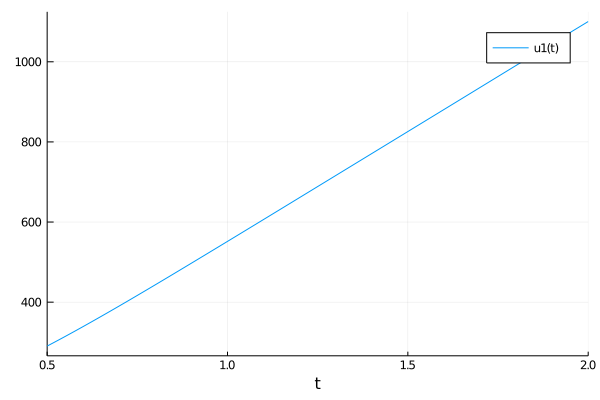

In [9]:
qa = [12; 40];
qe = [10; 50];
c0 = [5;10];
sigmasq = [3, 5];
gam = 1.5;

alpha_max = 2;
alpha_min = 0.5;

# alpha_span = (alpha_max,alpha_min);
alpha_span_reverse = (0.5, alpha_max);


params = [c0, qe, qa, sigmasq]

s_min_from_forward_solve = sol_standard[end]

s_min_guess = s_min_from_forward_solve
println("s_min_guess: ", s_min_guess)

ode_reverse_subs(s, p, α) = ds_da_ode( s, gam, α, params )
ode_reverse_prob = ODEProblem(ode_reverse_subs, s_min_guess, alpha_span_reverse)


sol_reverse =  DifferentialEquations.solve(ode_reverse_prob, Rodas5())
plot(sol_reverse)

## Solving the inverse -- Things Break, but Why?

If this is the correct solution, then using the right value for $s(\underline{\alpha})$ should work too....

But it doesn't! I can't figure out why...

In [37]:
using SpecialFunctions

function one_minus_F_over_f_uniform(z, a, b)
    if z < a 
        out = 0
    elseif z >= b
        out = 0
    else 
        out = (b - z) 
    end
end


function one_minus_F_over_f_truncated_lognormal(z, mu, sigma, a, b)
    
    if z < a
        out_fin = 0
    elseif z >= b
        out_fin = 0
    else 
        out = 0.5*sqrt(2)*sqrt(pi)*sigma*z
        out = out * (-erf(sqrt(2)*(mu - log(b))/(2*sigma)) + 1.0*erf(sqrt(2)*(mu - log(z))/(2*sigma)))
        out = out * exp((mu - log(z))^2/(2*sigma^2))
        out_fin = out

    end
    return(out_fin)
end



function getFracdV_V(s, γ, α, params)
    
    c, q_e, q_a, sigma_sq  = params
                                                                
    b = getBidStar( s, γ, α, params)
    db_ds = getDbDs( s, γ, α, b, params)

    b_min_c = b - (α*c);

    profit_ce = (q_a' * b_min_c) - (γ)*0.5 * ((sigma_sq .* b_min_c)' * b_min_c)
        
    dprofit_term = exp(-γ*profit_ce)*(1 - exp(-γ*profit_ce));
    
    dce = db_ds * ((γ .* q_a) - (γ^2 .* sigma_sq .* b_min_c) );
        
    dV_over_V = dprofit_term * dce;
    
    return(dV_over_V)
    
end

function getFracdV_V_w_prof(s, γ, α, params)
    
    c, q_e, q_a, sigma_sq  = params
                                                                
    b = getBidStar( s, γ, α, params)
    db_ds = getDbDs( s, γ, α, b, params)

    b_min_c = b - (α*c);

    profit_ce = (q_a' * b_min_c) - (γ)*0.5 * ((sigma_sq .* b_min_c)' * b_min_c)
        
    dprofit_term = exp(-γ*profit_ce)/(1 - exp(-γ*profit_ce));
    
    dce = db_ds * ((γ .* q_a) - (γ^2 .* sigma_sq .* b_min_c) );
        
    dV_over_V = dprofit_term * dce;
    
    return(profit_ce, dV_over_V)
    
end

function inverse_ds_da_ode( s, α, γ, params)
    
    oneMinusF_over_f = one_minus_F_over_f_uniform(α, 0.5, 2.0)
    
#     oneMinusF_over_f = one_minus_F_over_f_truncated_lognormal(α, 0.0, 0.3, 0.5, 2.0)

    profit_ce, dV_over_V = getFracdV_V_w_prof(s, α, γ, params)
    
    da_ds = profit_ce < 0 ? 1e-10 : dV_over_V * oneMinusF_over_f
    
    return(da_ds)

end


qa = [12; 40];
qe = [10; 50];
c0 = [5;10];
sigmasq = [3, 5];
gam = 1.5;

alpha_max = 2;
alpha_min = 0.5;


alpha_span_reverse = (0.5, alpha_max);

params = [c0, qe, qa, sigmasq]

s_min_from_forward_solve = sol_standard[end]

s_min_guess = s_min_from_forward_solve
println("s_min_guess: ", s_min_guess)

s_span = (s_min_from_forward_solve , s_max_computed)


ode_inverse_reverse_subs(α, p, s) = inverse_ds_da_ode( s, α, gam, params )
ode_inverse_reverse_prob = ODEProblem(ode_inverse_reverse_subs, alpha_min, s_span)

sol_inverse_reverse =  DifferentialEquations.solve(ode_inverse_reverse_prob,
                                            Rosenbrock23(autodiff=true)
                                            )


s_min_guess: 290.4369320206675


retcode: Success
Interpolation: specialized 2nd order "free" stiffness-aware interpolation
t: 9-element Array{Float64,1}:
  290.4369320206675 
  290.43703202066746
  290.43803202066744
  290.4480320206674 
  290.54803202066745
  291.54803202066745
  301.54803202066745
  401.5480320206674 
 1097.9867070962437 
u: 9-element Array{Float64,1}:
 0.5               
 0.50000000000001  
 0.50000000000011  
 0.50000000000111  
 0.50000000001111  
 0.50000000011111  
 0.50000000111111  
 0.50000001111111  
 0.5000000807549776

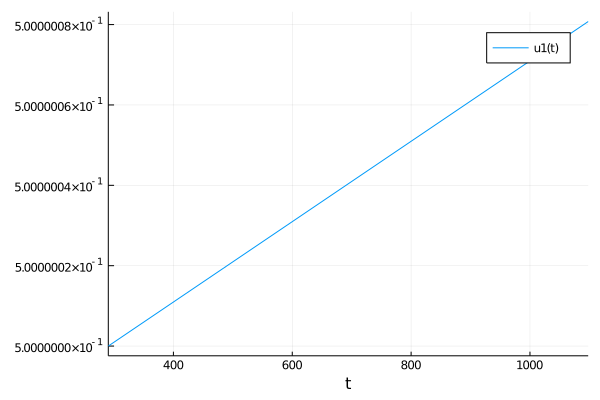

In [38]:
plot(sol_inverse_reverse)

## Shooting Algo?

In [9]:
gammas = [1.6, 1.5];
qa = [12; 40];
qe = [10; 50];
c = [5;10];
sigma_sq = [3, 5];
# gamma = 1.1;
params = [gammas, c, qe, qa, sigmasq]


alpha_max = 2.0
alpha_min = 0.5


function ode_asymmetric_riskaverse_multiitem!(ds, s, p, a)
    a_1, a_2 = a;  
    
    gammas, c, q_e, q_a, sigma_sq = p
    
    oneMinusFoverf1(x) = f_over_one_minus_F_uniform(x, 0.49999, 2.00001) 
    oneMinusFoverf2(x) = f_over_one_minus_F_uniform(x, 0.49999, 1.80001) 
    
    dprofit(x, g) = dinvbid_riskaverse_multiitem( s, x, g, c, q_e, q_a, sigma_sq)
    
    
    if a_1 >= 2.0 || a_1 < 0.5 
        da[1] = 0
    else
        VdV2 = getFracVdV(s, a_2, gammas[2], params)
        da[1] =   oneMinusFoverf1(a_1) * VdV2
    end
    
    if a_2 >= 1.8  || a_2 < 0.5 
        da[2] = 0
    else
        VdV1 = getFracVdV(s, a_1, gammas[1], params)
        
        da[2] = oneMinusFoverf2(a_2) * VdV1
    end
    
    @show ds
#     return(ds)

end

ode_asymmetric_riskaverse_multiitem! (generic function with 1 method)